In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv
/kaggle/input/playground-series-s3e9/sample_submission.csv
/kaggle/input/playground-series-s3e9/train.csv
/kaggle/input/playground-series-s3e9/test.csv
/kaggle/input/model-img/model.png
/kaggle/input/strength/eightcolumns.csv
/kaggle/input/strength/fivecolumns.csv


# 1. Importing Libraries

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold 
# from PIL import Image

from bayes_opt import BayesianOptimization

import optuna
from sklearn.datasets import load_breast_cancer
# from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import StratifiedKFold

# 2. Read Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e9/train.csv')
train = train.drop('id' ,axis = 1)
test = pd.read_csv('/kaggle/input/playground-series-s3e9/test.csv')
test = test.drop('id' ,axis = 1)

# 5. Descriptive Statistics

In [4]:
train.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
CementComponent,5407.000000,299.168189,105.537682,102.000000,213.700000,297.200000,375.000000,540.000000
BlastFurnaceSlag,5407.000000,58.610579,83.417801,0.000000,0.000000,0.000000,122.600000,359.400000
FlyAshComponent,5407.000000,31.872795,54.605003,0.000000,0.000000,0.000000,79.000000,200.100000
WaterComponent,5407.000000,185.076235,18.517583,121.800000,175.100000,187.400000,192.000000,247.000000
SuperplasticizerComponent,5407.000000,4.108441,5.692296,0.000000,0.000000,0.000000,8.050000,32.200000
CoarseAggregateComponent,5407.000000,992.000718,77.148010,801.000000,938.200000,978.000000,1047.000000,1145.000000
FineAggregateComponent,5407.000000,771.219974,78.725253,594.000000,734.300000,781.200000,821.000000,992.600000
AgeInDays,5407.000000,51.751618,70.006975,1.000000,7.000000,28.000000,56.000000,365.000000
Strength,5407.000000,35.452071,16.401896,2.330000,23.640000,33.950000,45.850000,82.600000


# 6. Correlation Matrix

<AxesSubplot:>

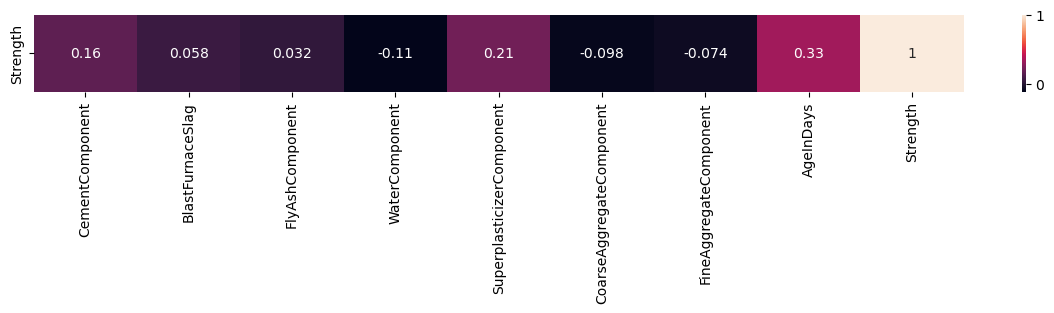

In [5]:
# Pearson Corrleation Matrix
%matplotlib inline
plt.figure(figsize = (15,1))
pea = train.corr(method='pearson').tail(1)
sns.heatmap( pea ,annot=True)

<AxesSubplot:>

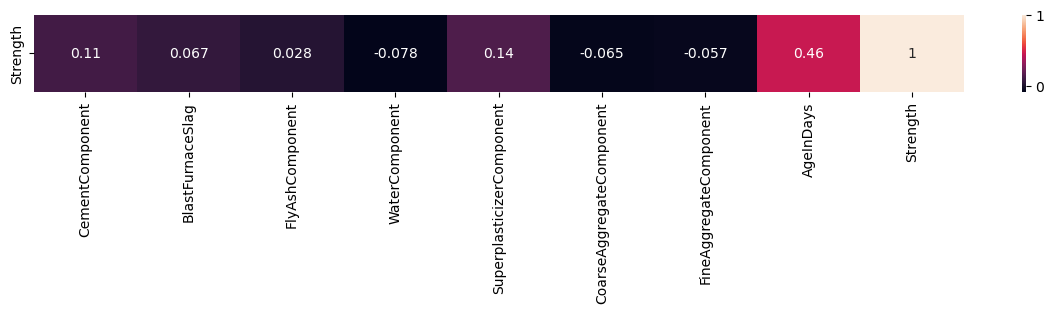

In [6]:
# kendall Corrleation Matrix
%matplotlib inline
plt.figure(figsize = (15,1))
ken = train.corr(method='kendall').tail(1)
sns.heatmap( ken ,annot=True)

# 12. Model building

In [7]:
# zero_left = train[(train['BlastFurnaceSlag'] == 0) & (train['FlyAshComponent'] == 0) & (train['SuperplasticizerComponent'] == 0)]
# without_zero = train.drop(zero_left.index)
# zero_left = zero_left.drop(['BlastFurnaceSlag' , 'FlyAshComponent' ,'SuperplasticizerComponent'] ,axis = 1)
# zero_left.to_csv('fivecolumns.csv' , index =False)
# without_zero.to_csv('eightcolumns.csv',index = False)

In [8]:
data1 = pd.read_csv('/kaggle/input/strength/fivecolumns.csv')
data1.head()

,CementComponent,WaterComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,186.0,1125.0,613.0,3,10.38
1,350.0,203.0,1055.0,775.0,7,37.43
2,322.0,203.0,974.0,800.0,180,42.14
3,500.0,200.0,1125.0,613.0,270,65.20
4,331.0,192.0,978.0,825.0,28,24.48


In [9]:
data1U = pd.DataFrame()
data1U['Water_Cement'] = data1['WaterComponent']/data1['CementComponent']
data1U['Coarse_Fine'] = data1['CoarseAggregateComponent']/data1['FineAggregateComponent']
data1U['Aggregate'] = data1['CoarseAggregateComponent'] + data1['FineAggregateComponent']
data1U['Aggregate_Cement'] = data1U['Aggregate']/data1['CementComponent']
data1U['Age_Water'] = data1['AgeInDays']/data1['WaterComponent']
data1U['Strength'] = data1['Strength']

In [10]:
data1U.head()

,Water_Cement,Coarse_Fine,Aggregate,Aggregate_Cement,Age_Water,Strength
0,0.354286,1.835237,1738.0,3.310476,0.016129,10.38
1,0.580000,1.361290,1830.0,5.228571,0.034483,37.43
2,0.630435,1.217500,1774.0,5.509317,0.886700,42.14
3,0.400000,1.835237,1738.0,3.476000,1.350000,65.20
4,0.580060,1.185455,1803.0,5.447130,0.145833,24.48


In [11]:
# df['Water_Cement'] = df['WaterComponent']/df['CementComponent']
# df['Coarse_Fine'] = df['CoarseAggregateComponent']/df['FineAggregateComponent']
# df['Aggregate'] = df['CoarseAggregateComponent'] + df['FineAggregateComponent']
# df['Aggregate_Cement'] = df['Aggregate']/df['CementComponent']
# df['Slag_Cement'] = df['BlastFurnaceSlag']/df['CementComponent']
# df['Ash_Cement'] = df['FlyAshComponent']/df['CementComponent']
# df['Plastic_Cement'] = df['SuperplasticizerComponent']/df['CementComponent']
# df['Age_Water'] = df['AgeInDays']/df['WaterComponent']

In [12]:
X = data1U.drop('Strength' ,axis =1)
y = data1U.Strength

In [13]:
# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 100, 1000, step=100),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
#         "depth": trial.suggest_int("depth", 4, 10),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 1e2, log=True),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
#         "border_count": trial.suggest_int("border_count", 32, 255, step=32),
#         "random_seed": 42
#     }
    

    
#     model = CatBoostRegressor(**params, silent=True)

#     model.fit(X,y)
#     r = mean_squared_error(y, model.predict(X),squared=False)
#     return r

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best_hyperparameters: ', study.best_params)
# print('Best_rmse: ', study.best_value)

In [14]:

# def objective(trial):
#     params = {"n_estimators":trial.suggest_int('n_estimators', 50,1000),
#         "eta": trial.suggest_float("eta", 0.01, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "min_child_weight": trial.suggest_float("min_child_weight", 0.1, 10),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "lambda": trial.suggest_float("lambda", 0, 10),
#         "alpha": trial.suggest_float("alpha", 0, 10),
#         "random_state": 42
#     }
    

    
#     model = XGBRegressor(**params, silent=True)

#     model.fit(X,y)
#     r = mean_squared_error(y, model.predict(X),squared=False)
#     return r

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best_hyperparameters: ', study.best_params)
# print('Best_rmse: ', study.best_value)


In [15]:

# def objective(trial):
#     params = {"n_estimators":trial.suggest_int('n_estimators', 50,1000),
#         "objective": "regression",
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "num_leaves": trial.suggest_int("num_leaves", 10, 1000),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
#         "lambda_l1": trial.suggest_float("lambda_l1", 0, 10),
#         "lambda_l2": trial.suggest_float("lambda_l2", 0, 10),
#         "random_state": 42
#     }
    

    
#     model = LGBMRegressor(**params, silent=True)

#     model.fit(X,y)
#     r = mean_squared_error(y, model.predict(X),squared=False)
#     return r

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best_hyperparameters: ', study.best_params)
# print('Best_rmse: ', study.best_value)


In [16]:
lgb_hyperparameters = {'n_estimators': 814, 'learning_rate': 0.2937775464636304, 'max_depth': 10, 'num_leaves': 372, 'feature_fraction': 0.8296430029298342, 'bagging_fraction': 0.7153305720820494, 'lambda_l1': 0.75243642722118, 'lambda_l2': 0.008234214904501786}
# Best_rmse:  8.759894242762075
    
    
catboost_hyperparameters= {'iterations': 1000, 'learning_rate': 0.099530306160531, 'depth': 10, 'l2_leaf_reg': 0.0009432436315020325, 'bagging_temperature': 8.986758813626793, 'border_count': 64}
# Best_rmse:  8.671966089885006
    
    
XGB_hyperparameters = {'n_estimators': 624, 'eta': 0.24664894894176886, 'max_depth': 10, 'min_child_weight': 1.1063720875150618, 'subsample': 0.9995751483339743, 'colsample_bytree': 0.8710062779351881, 'lambda': 6.789942957522003, 'alpha': 0.29600624916416296}
# Best_rmse:  8.744503269936352

In [17]:
lgb_data1 = LGBMRegressor(**lgb_hyperparameters)
lgb_data1.fit(X,y)
cat_data1 = CatBoostRegressor(**catboost_hyperparameters ,silent=True)
cat_data1.fit(X,y)
xgb_data1 = XGBRegressor(**XGB_hyperparameters)
xgb_data1.fit(X,y)


[LightGBM] [Warning] lambda_l1 is set=0.75243642722118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.75243642722118
[LightGBM] [Warning] feature_fraction is set=0.8296430029298342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8296430029298342
[LightGBM] [Warning] lambda_l2 is set=0.008234214904501786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008234214904501786
[LightGBM] [Warning] bagging_fraction is set=0.7153305720820494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7153305720820494


XGBRegressor(alpha=0.29600624916416296, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.8710062779351881, early_stopping_rounds=None,
             enable_categorical=False, eta=0.24664894894176886,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             lambda=6.789942957522003, learning_rate=0.246648952, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
             min_child_weight=1.1063720875150618, missing=nan,
             monotone_constraints='()', n_estimators=624, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [18]:
data1_stack = pd.DataFrame()
data1_stack['lgb'] = lgb_data1.predict(X)
data1_stack['cat'] = cat_data1.predict(X)
data1_stack['xgb'] = xgb_data1.predict(X)
data1_stack['original'] = y


In [19]:
# Coefficient Optimizing
# def obj(a,b,c):
#     pred = data1_stack['lgb']*a +data1_stack['cat']*b +data1_stack['xgb']*c
    
#     rmse = mean_squared_error(data1_stack.original , pred ,squared=False)
    
#     return -rmse

# optimizer = BayesianOptimization(f = obj ,pbounds={'a':(0,1),
#                                                   'b':(0,1),
#                                                   'c':(0,1)} ,allow_duplicate_points=True )
# optimizer.maximize(init_points=5 ,n_iter=100)

# print("best_value" , optimizer.max)

In [20]:
# (init_points 15- n_iter 50)
# best_value{'target': -8.68865154630771, 'params': {'a': 0.0, 'b': 0.6015394786455033, 'c': 0.39288199277520414}}
#(init_points 5 - n_iter_100)
# best_value {'target': -8.672062791820608, 'params': {'a': 0.0, 'b': 1.0, 'c': 0.0}}

In [21]:
X = data1_stack.drop('original' ,axis=1)
y = data1_stack.original

In [22]:
# def objective(trial):
#     params = {"n_estimators":trial.suggest_int('n_estimators', 50,1000),
#         "eta": trial.suggest_float("eta", 0.01, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "min_child_weight": trial.suggest_float("min_child_weight", 0.1, 10),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "lambda": trial.suggest_float("lambda", 0, 10),
#         "alpha": trial.suggest_float("alpha", 0, 10),
#         "random_state": 42
#     }
    

    
#     model = XGBRegressor(**params, silent=True)

#     model.fit(X,y)
#     r = mean_squared_error(y, model.predict(X),squared=False)
#     return r

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best_hyperparameters: ', study.best_params)
# print('Best_rmse: ', study.best_value)

In [23]:
# {'n_estimators': 864, 'eta': 0.02933082358597977, 'max_depth': 8, 'min_child_weight': 0.28563337898254204, 'subsample': 0.9990419418642175, 'colsample_bytree': 0.6906440163879248, 'lambda': 3.9637159896568046, 'alpha': 1.1986400719358095}

In [24]:

# def objective(trial):
#     params = {"n_estimators":trial.suggest_int('n_estimators', 50,1000),
#         "objective": "regression",
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "num_leaves": trial.suggest_int("num_leaves", 10, 1000),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
#         "lambda_l1": trial.suggest_float("lambda_l1", 0, 10),
#         "lambda_l2": trial.suggest_float("lambda_l2", 0, 10),
#         "random_state": 42
#     }
    

    
#     model = LGBMRegressor(**params, silent=True)

#     model.fit(X,y)
#     r = mean_squared_error(y, model.predict(X),squared=False)
#     return r

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best_hyperparameters: ', study.best_params)
# print('Best_rmse: ', study.best_value)

In [25]:








# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 100, 1000, step=100),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
#         "depth": trial.suggest_int("depth", 4, 10),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 1e2, log=True),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
#         "border_count": trial.suggest_int("border_count", 32, 255, step=32),
#         "random_seed": 42
#     }
    

    
#     model = CatBoostRegressor(**params, silent=True)

#     model.fit(X,y)
#     r = mean_squared_error(y, model.predict(X),squared=False)
#     return r

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best_hyperparameters: ', study.best_params)
# print('Best_rmse: ', study.best_value)


In [26]:




XGB_hyperparameters_final = {'n_estimators': 864, 'eta': 0.02933082358597977, 'max_depth': 8, 'min_child_weight': 0.28563337898254204, 'subsample': 0.9990419418642175, 'colsample_bytree': 0.6906440163879248, 'lambda': 3.9637159896568046, 'alpha': 1.1986400719358095}
# Best_rmse:  8.671118199999102
    
# lgb_Best_hyperparameters:  {'n_estimators': 953, 'learning_rate': 0.2720068359368248, 'max_depth': 8, 'num_leaves': 877, 'feature_fraction': 0.666760254198479, 'bagging_fraction': 0.6253084725017961, 'lambda_l1': 0.0038426664304350155, 'lambda_l2': 3.744575802556337}
# Best_rmse:  8.679303952735054
    
    
# cat_hyperparameters:  {'iterations': 1000, 'learning_rate': 0.09351617016583201, 'depth': 10, 'l2_leaf_reg': 0.0025846140981067335, 'bagging_temperature': 1.2387735437922007, 'border_count': 224}
# Best_rmse:  8.67176763811121


# (init_points 15- n_iter 50)
# 'Best_rmse': -8.68865154630771, 'params': {'a': 0.0, 'b': 0.6015394786455033, 'c': 0.39288199277520414}


#(init_points 5 - n_iter_100)
# Best_rmse': -8.672062791820608, 'params': {'a': 0.0, 'b': 1.0, 'c': 0.0}

In [27]:
XGB_final_data1 = XGBRegressor(**XGB_hyperparameters_final)
XGB_final_data1.fit(X,y)

XGBRegressor(alpha=1.1986400719358095, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.6906440163879248, early_stopping_rounds=None,
             enable_categorical=False, eta=0.02933082358597977,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             lambda=3.9637159896568046, learning_rate=0.0293308236, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=8, max_leaves=0,
             min_child_weight=0.28563337898254204, missing=nan,
             monotone_constraints='()', n_estimators=864, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [28]:
data2 = pd.read_csv('/kaggle/input/strength/eightcolumns.csv')

In [29]:
data2.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
1,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
2,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
3,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
4,135.7,203.5,0.0,185.7,0.0,1076.2,759.3,28,35.10


In [30]:
data2U = pd.DataFrame()

data2U['Water_Cement'] = data2['WaterComponent']/data2['CementComponent']
data2U['Coarse_Fine'] = data2['CoarseAggregateComponent']/data2['FineAggregateComponent']
data2U['Aggregate'] = data2['CoarseAggregateComponent'] + data2['FineAggregateComponent']
data2U['Aggregate_Cement'] = data2U['Aggregate']/data2['CementComponent']
data2U['Slag_Cement'] = data2['BlastFurnaceSlag']/data2['CementComponent']
data2U['Ash_Cement'] = data2['FlyAshComponent']/data2['CementComponent']
data2U['Plastic_Cement'] = data2['SuperplasticizerComponent']/data2['CementComponent']
data2U['Age_Water'] = data2['AgeInDays']/data2['WaterComponent']
data2U['Strength'] = data2.Strength


In [31]:
data2U.head()

,Water_Cement,Coarse_Fine,Aggregate,Aggregate_Cement,Slag_Cement,Ash_Cement,Plastic_Cement,Age_Water,Strength
0,1.335664,1.503888,1610.0,11.258741,1.181818,1.0,0.055944,0.146597,23.52
1,0.642561,1.351691,1870.3,6.471626,0.466090,0.0,0.000000,0.150781,36.96
2,0.750000,1.391045,1602.0,5.269737,0.250000,0.0,0.000000,1.600877,39.05
3,1.222930,1.197389,1716.6,10.933758,1.503185,0.0,0.000000,0.468750,74.19
4,1.368460,1.417358,1835.5,13.526161,1.499632,0.0,0.000000,0.150781,35.10


In [32]:
X = data2U.drop('Strength' ,axis =1)
y = data2U.Strength

In [33]:
# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 100, 1000, step=100),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
#         "depth": trial.suggest_int("depth", 4, 10),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 1e2, log=True),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
#         "border_count": trial.suggest_int("border_count", 32, 255, step=32),
#         "random_seed": 42
#     }
    

    
#     model = CatBoostRegressor(**params, silent=True)

#     model.fit(X,y)
#     r = mean_squared_error(y, model.predict(X),squared=False)
#     return r

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best_hyperparameters: ', study.best_params)
# print('Best_rmse: ', study.best_value)







In [34]:
# def objective(trial):
#     params = {"n_estimators":trial.suggest_int('n_estimators', 50,1000),
#         "eta": trial.suggest_float("eta", 0.01, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "min_child_weight": trial.suggest_float("min_child_weight", 0.1, 10),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "lambda": trial.suggest_float("lambda", 0, 10),
#         "alpha": trial.suggest_float("alpha", 0, 10),
#         "random_state": 42
#     }
    

    
#     model = XGBRegressor(**params, silent=True)

#     model.fit(X,y)
#     r = mean_squared_error(y, model.predict(X),squared=False)
#     return r

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best_hyperparameters: ', study.best_params)
# print('Best_rmse: ', study.best_value)



In [35]:
{'n_estimators': 741, 'eta': 0.23318893587533493, 'max_depth': 10, 'min_child_weight': 0.7479744834220452, 'subsample': 0.9848210493362, 'colsample_bytree': 0.9169271670669533, 'lambda': 9.967170487838125, 'alpha': 0.5815144453300983}

{'n_estimators': 741,
 'eta': 0.23318893587533493,
 'max_depth': 10,
 'min_child_weight': 0.7479744834220452,
 'subsample': 0.9848210493362,
 'colsample_bytree': 0.9169271670669533,
 'lambda': 9.967170487838125,
 'alpha': 0.5815144453300983}

In [36]:
# def objective(trial):
#     params = {"n_estimators":trial.suggest_int('n_estimators', 50,1000),
#         "objective": "regression",
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "num_leaves": trial.suggest_int("num_leaves", 10, 1000),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
#         "lambda_l1": trial.suggest_float("lambda_l1", 0, 10),
#         "lambda_l2": trial.suggest_float("lambda_l2", 0, 10),
#         "random_state": 42
#     }
    

    
#     model = LGBMRegressor(**params, silent=True)

#     model.fit(X,y)
#     r = mean_squared_error(y, model.predict(X),squared=False)
#     return r

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best_hyperparameters: ', study.best_params)
# print('Best_rmse: ', study.best_value)


In [37]:
CAT_Best_hyperparameters ={'iterations': 900, 'learning_rate': 0.09989665806720584, 'depth': 10, 'l2_leaf_reg': 0.12515936923082566, 'bagging_temperature': 2.148481928571176, 'border_count': 192}
# Best_rmse:  6.687477074255536
    
    

XGB_Best_hyperparameters = {'n_estimators': 741, 'eta': 0.23318893587533493, 'max_depth': 10, 'min_child_weight': 0.7479744834220452, 'subsample': 0.9848210493362, 'colsample_bytree': 0.9169271670669533, 'lambda': 9.967170487838125, 'alpha': 0.5815144453300983}
# Best_rmse:  6.614808798383476




LGBM_Best_hyperparameters =  {'n_estimators': 957, 'learning_rate': 0.2989333261566501, 'max_depth': 10, 'num_leaves': 230, 'feature_fraction': 0.986374262881006, 'bagging_fraction': 0.787372021223232, 'lambda_l1': 2.098698697133398, 'lambda_l2': 1.953316278280273}
# Best_rmse:  6.695536758539405

In [38]:
lgb_data2 = LGBMRegressor(**LGBM_Best_hyperparameters)
lgb_data2.fit(X,y)
cat_data2 = CatBoostRegressor(**CAT_Best_hyperparameters,silent=True)
cat_data2.fit(X,y)
xgb_data2 = XGBRegressor(**XGB_Best_hyperparameters)
xgb_data2.fit(X,y)


[LightGBM] [Warning] lambda_l1 is set=2.098698697133398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.098698697133398
[LightGBM] [Warning] feature_fraction is set=0.986374262881006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.986374262881006
[LightGBM] [Warning] lambda_l2 is set=1.953316278280273, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.953316278280273
[LightGBM] [Warning] bagging_fraction is set=0.787372021223232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.787372021223232


XGBRegressor(alpha=0.5815144453300983, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.9169271670669533, early_stopping_rounds=None,
             enable_categorical=False, eta=0.23318893587533493,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             lambda=9.967170487838125, learning_rate=0.233188942, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
             min_child_weight=0.7479744834220452, missing=nan,
             monotone_constraints='()', n_estimators=741, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [39]:
data2_stack = pd.DataFrame()
data2_stack['lgb'] = lgb_data2.predict(X)
data2_stack['cat'] = cat_data2.predict(X)
data2_stack['xgb'] = xgb_data2.predict(X)
data2_stack['original'] = y


In [40]:
data2_stack.head()

,lgb,cat,xgb,original
0,24.075671,24.302491,23.603813,23.52
1,37.050015,37.320000,36.967484,36.96
2,40.012906,39.652308,40.345432,39.05
3,52.559146,52.508604,52.548042,74.19
4,28.630165,28.595055,28.685724,35.10


In [41]:
X = data2_stack.drop('original' ,axis = 1)
y = data2_stack.original

In [42]:
# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 100, 1000, step=100),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
#         "depth": trial.suggest_int("depth", 4, 10),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 1e2, log=True),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
#         "border_count": trial.suggest_int("border_count", 32, 255, step=32),
#         "random_seed": 42
#     }
    

    
#     model = CatBoostRegressor(**params, silent=True)

#     model.fit(X,y)
#     r = mean_squared_error(y, model.predict(X),squared=False)
#     return r

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best_hyperparameters: ', study.best_params)
# print('Best_rmse: ', study.best_value)


In [43]:
Best_hyperparameters:  {'iterations': 700, 'learning_rate': 0.09646300573596985, 'depth': 10, 'l2_leaf_reg': 0.026446447721406655, 'bagging_temperature': 2.472495540093936, 'border_count': 224}
Best_rmse:  6.613897206580522

In [44]:

# def objective(trial):
#     params = {"n_estimators":trial.suggest_int('n_estimators', 50,1000),
#         "eta": trial.suggest_float("eta", 0.01, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "min_child_weight": trial.suggest_float("min_child_weight", 0.1, 10),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "lambda": trial.suggest_float("lambda", 0, 10),
#         "alpha": trial.suggest_float("alpha", 0, 10),
#         "random_state": 42
#     }
    

    
#     model = XGBRegressor(**params, silent=True)

#     model.fit(X,y)
#     r = mean_squared_error(y, model.predict(X),squared=False)
#     return r

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best_hyperparameters: ', study.best_params)
# print('Best_rmse: ', study.best_value)

In [45]:
# # # Coefficient Optimizing
# # def obj(a,b,c):
# #     pred = data2_stack['lgb']*a +data2_stack['cat']*b +data2_stack['xgb']*c
    
# #     rmse = mean_squared_error(data2_stack.original , pred ,squared=False)
    
# #     return -rmse

# # optimizer = BayesianOptimization(f = obj ,pbounds={'a':(0,1),
# #                                                   'b':(0,1),
# #                                                   'c':(0,1)} ,allow_duplicate_points=True )
# # optimizer.maximize(init_points=10,n_iter=100)

# # print("best_value" , optimizer.max)









# def objective(trial):
#     params = {"n_estimators":trial.suggest_int('n_estimators', 50,1000),
#         "objective": "regression",
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "num_leaves": trial.suggest_int("num_leaves", 10, 1000),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
#         "lambda_l1": trial.suggest_float("lambda_l1", 0, 10),
#         "lambda_l2": trial.suggest_float("lambda_l2", 0, 10),
#         "random_state": 42
#     }
    

    
#     model = LGBMRegressor(**params, silent=True)

#     model.fit(X,y)
#     r = mean_squared_error(y, model.predict(X),squared=False)
#     return r

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Best_hyperparameters: ', study.best_params)
# print('Best_rmse: ', study.best_value)





In [46]:
{'n_estimators': 883, 'eta': 0.1414457248411872, 'max_depth': 10, 'min_child_weight': 7.334263059494213, 'subsample': 0.9995394981805414, 'colsample_bytree': 0.7165431578112451, 'lambda': 4.205836994720299, 'alpha': 0.0034839668675774593}
Best_rmse:  6.612928783491534

In [47]:
Best_hyperparameters:  {'n_estimators': 924, 'learning_rate': 0.17638618844678497, 'max_depth': 8, 'num_leaves': 855, 'feature_fraction': 0.5127943139589903, 'bagging_fraction': 0.6523624031748408, 'lambda_l1': 0.06308512186880688, 'lambda_l2': 8.055363150449166}
Best_rmse:  6.615807850217292

In [48]:
# COefficient_opitmized
# best_value  = { 'params': {'a': 0.2035611442458889, 'b': 0.0028528344055466226, 'c': 0.7894776034220363}}
# 'target': -6.623851050856059,

In [49]:
{'iterations': 1000, 'learning_rate': 0.09967161752105742, 'depth': 10, 'l2_leaf_reg': 0.000387618420532532, 'bagging_temperature': 7.089621677091551, 'border_count': 224}

{'iterations': 1000,
 'learning_rate': 0.09967161752105742,
 'depth': 10,
 'l2_leaf_reg': 0.000387618420532532,
 'bagging_temperature': 7.089621677091551,
 'border_count': 224}

In [50]:
# CAT_Best_final_hyperparameters = {'iterations': 1000, 'learning_rate': 0.09247625220898988, 'depth': 10, 'l2_leaf_reg': 0.00025289581186112894, 'bagging_temperature': 1.5502200957469692, 'border_count': 224}
# Best_rmse:  6.613816650116042
    
    
XGB_Best_hyperparameters =  {'n_estimators': 883, 'eta': 0.1414457248411872, 'max_depth': 10, 'min_child_weight': 7.334263059494213, 'subsample': 0.9995394981805414, 'colsample_bytree': 0.7165431578112451, 'lambda': 4.205836994720299, 'alpha': 0.0034839668675774593}
Best_rmse:  6.614578573571923
    
    
# lgb_hyperparameters = {'n_estimators': 951, 'learning_rate': 0.2996675895657098, 'max_depth': 9, 'num_leaves': 865, 'feature_fraction': 0.8573621172448175, 'bagging_fraction': 0.7670567902072594, 'lambda_l1': 0.029622343270187684, 'lambda_l2': 2.829385931735908}
# Best_rmse:  6.616727061010832

In [51]:
X.head(2)

,lgb,cat,xgb
0,24.075671,24.302491,23.603813
1,37.050015,37.320000,36.967484


In [52]:
FINAL_CAT = XGBRegressor(**XGB_Best_hyperparameters)
FINAL_CAT.fit(X,y)

XGBRegressor(alpha=0.0034839668675774593, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7165431578112451, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1414457248411872, eval_metric=None,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', lambda=4.205836994720299,
             learning_rate=0.141445726, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0,
             min_child_weight=7.334263059494213, missing=nan,
             monotone_constraints='()', n_estimators=883, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

# Prediction on Test

In [53]:
zero_left = test[(test['BlastFurnaceSlag'] == 0) & (test['FlyAshComponent'] == 0) & (test['SuperplasticizerComponent'] == 0)]
data2 = test.drop(zero_left.index)
data1 = zero_left.drop(['BlastFurnaceSlag' , 'FlyAshComponent' ,'SuperplasticizerComponent'] ,axis = 1)

In [54]:
data1U = pd.DataFrame()
data1U['Water_Cement'] = data1['WaterComponent']/data1['CementComponent']
data1U['Coarse_Fine'] = data1['CoarseAggregateComponent']/data1['FineAggregateComponent']
data1U['Aggregate'] = data1['CoarseAggregateComponent'] + data1['FineAggregateComponent']
data1U['Aggregate_Cement'] = data1U['Aggregate']/data1['CementComponent']
data1U['Age_Water'] = data1['AgeInDays']/data1['WaterComponent']

In [55]:
data1U.iloc[:,:5]

,Water_Cement,Coarse_Fine,Aggregate,Aggregate_Cement,Age_Water
1,0.625000,1.245943,1799.0,5.917763,0.036842
2,0.822222,1.336134,1946.0,8.648889,0.151351
13,0.528191,1.373295,1809.4,4.812234,1.359517
20,0.580060,1.185455,1803.0,5.447130,0.015625
21,0.483627,1.240106,1698.0,4.277078,0.015625
...,...,...,...,...,...
3595,0.480000,1.569024,1526.0,3.212632,1.184211
3596,0.580060,1.185455,1803.0,5.447130,0.468750
3597,0.619355,1.219277,1842.0,5.941935,0.036458
3598,0.550143,1.299007,1853.0,5.309456,0.468750


In [56]:
data1U['lgb'] = lgb_data1.predict(data1U.iloc[:,:5])
data1U['cat']  = cat_data1.predict(data1U.iloc[:,:5])
data1U['xgb'] = xgb_data1.predict(data1U.iloc[:,:5])
data1U['final'] = XGB_final_data1.predict(data1U[['lgb','cat','xgb']])

In [57]:
data2U = pd.DataFrame()

data2U['Water_Cement'] = data2['WaterComponent']/data2['CementComponent']
data2U['Coarse_Fine'] = data2['CoarseAggregateComponent']/data2['FineAggregateComponent']
data2U['Aggregate'] = data2['CoarseAggregateComponent'] + data2['FineAggregateComponent']
data2U['Aggregate_Cement'] = data2U['Aggregate']/data2['CementComponent']
data2U['Slag_Cement'] = data2['BlastFurnaceSlag']/data2['CementComponent']
data2U['Ash_Cement'] = data2['FlyAshComponent']/data2['CementComponent']
data2U['Plastic_Cement'] = data2['SuperplasticizerComponent']/data2['CementComponent']
data2U['Age_Water'] = data2['AgeInDays']/data2['WaterComponent']
# data2U['Strength'] = data2.Strength


In [58]:
data2U.head()

,Water_Cement,Coarse_Fine,Aggregate,Aggregate_Cement,Slag_Cement,Ash_Cement,Plastic_Cement,Age_Water
0,1.046358,1.349049,1753.8,10.558700,0.453943,0.986153,0.027694,0.322209
3,0.749801,1.357265,1786.1,7.104614,0.000000,0.470565,0.025457,0.530504
4,1.222222,1.440056,1730.0,12.013889,0.104167,1.354167,0.041667,0.159091
5,0.746468,1.053391,1623.0,6.197022,0.423826,0.334097,0.022528,0.143223
6,1.160000,1.581361,1745.0,11.633333,0.000000,0.000000,0.016667,0.160920


In [59]:
data2U['lgb'] = lgb_data2.predict(data2U.iloc[:,:8])
data2U['cat'] = cat_data2.predict(data2U.iloc[:,:8])
data2U['xgb'] = xgb_data2.predict(data2U.iloc[:,:8])
data2U['final'] = FINAL_CAT.predict(data2U[['lgb' , 'cat' ,'xgb']])

In [60]:
data2U.head()

,Water_Cement,Coarse_Fine,Aggregate,Aggregate_Cement,Slag_Cement,Ash_Cement,Plastic_Cement,Age_Water,lgb,cat,xgb,final
0,1.046358,1.349049,1753.8,10.558700,0.453943,0.986153,0.027694,0.322209,40.142840,46.451931,46.624214,45.834236
3,0.749801,1.357265,1786.1,7.104614,0.000000,0.470565,0.025457,0.530504,47.440228,47.639309,47.283054,46.933079
4,1.222222,1.440056,1730.0,12.013889,0.104167,1.354167,0.041667,0.159091,15.164180,29.534035,20.435207,19.360554
5,0.746468,1.053391,1623.0,6.197022,0.423826,0.334097,0.022528,0.143223,39.864393,44.440668,32.272144,33.346909
6,1.160000,1.581361,1745.0,11.633333,0.000000,0.000000,0.016667,0.160920,14.074184,30.816081,26.309036,23.780430


In [61]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e9/sample_submission.csv')
sub.loc[data1U['final'].index, "Strength"] = data1U.final
sub.loc[data2U['final'].index, "Strength"] = data2U.final
sub.to_csv('submission.csv' , index =False)

In [62]:
sub.head()

,id,Strength
0,5407,45.834236
1,5408,18.827299
2,5409,35.744408
3,5410,46.933079
4,5411,19.360554
